<a href="https://colab.research.google.com/github/akalakkad/Silly-Gans/blob/master/Flower_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flower GAN

Another exercise with training DCGAN on a set of flowers. The model was trained over 100 epochs with betas of .4 for both Gan and Discriminator. Learning rate was kept at .0002 and an extra convolutional layer was added to the disrcriminator. Image size was initially meant to be 64X64 but I ended up dropping it back down to 32X32. 

Interestingly enough the model does Daisies and Sunflowers really well. Anything else becomes blurry. Im wondering if its the contrasting background or colors that are easier to learn than the blending of blues and greens in a lot of the photos. The detail is low as well given the small image size. 


In [0]:
!curl -O http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz

In [0]:
!tar -xvzf 17flowers.tgz

In [0]:
import os
import numpy as np
import keras
import keras.backend as K
from keras.layers import Dense, Activation, BatchNormalization, LeakyReLU, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split

In [0]:
path = 'jpg'

In [0]:
def import_images(path):
  array = []
  for p in os.listdir(path):
    img = Image.open(path + "/" + p)
    resize = img.resize((32,32))
    img_array = np.array(resize, dtype='float32')
    array.append(img_array)
  
  return array
   

In [0]:
images = import_images(path)

In [0]:
X_train, X_test = train_test_split(images, train_size=.7, test_size=.3, random_state=6)

In [0]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [0]:
def processImages(x):
  
  return (x/255)*2 - 1

In [0]:
def deprocessImages(x):
  
  return np.uint8((x+1)/2*255)

In [0]:
X_train_real = processImages(X_train)
X_test_real = processImages(X_test)

In [0]:
def make_generator(input_size, leaky_alpha):
  
  return Sequential([
      Dense(4*4*512, input_shape=(input_size,)),
      Reshape(target_shape=(4,4,512)),
      BatchNormalization(),
      LeakyReLU(alpha=leaky_alpha),
      Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'),
      BatchNormalization(),
      LeakyReLU(alpha=leaky_alpha),
      Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'),
      BatchNormalization(),
      LeakyReLU(alpha=leaky_alpha),
      Conv2DTranspose(3, kernel_size=5, strides=2, padding='same'),
      Activation('tanh')
  ])

In [0]:
def make_discriminator(leaky_alpha):
  
  return Sequential([
      Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(32,32,3)),
      LeakyReLU(alpha=leaky_alpha),
      Conv2D(128, kernel_size=5, strides=2, padding='same'),
      BatchNormalization(),
      LeakyReLU(alpha=leaky_alpha),
      Conv2D(256, kernel_size=5, strides=2, padding='same'),
      BatchNormalization(),
      LeakyReLU(alpha=leaky_alpha),
      Conv2D(512, kernel_size=5, strides=2, padding='same'),
      BatchNormalization(),
      LeakyReLU(alpha=leaky_alpha),
      Flatten(),
      Dense(1),
      Activation('sigmoid')
  ])

In [0]:
def make_DCGAN(sample_size, g_learning_rate, g_beta_1, d_learning_rate, d_beta_1, leaky_alpha):
  
  K.clear_session()
  
  generator = make_generator(sample_size, leaky_alpha)
  
  discriminator = make_discriminator(leaky_alpha)
  discriminator.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy')
  
  gan = Sequential([generator, discriminator])
  gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
  
  return gan, generator, discriminator

In [0]:
def make_latent_samples(n_samples, sample_size):
  
  return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [0]:
def make_trainable(model, trainable):
  for layer in model.layers:
    layer.trainable = trainable

In [0]:
def make_labels(size):
  
  return np.ones([size, 1]), np.zeros([size, 1]) 

In [0]:
def show_losses(losses):
  losses = np.array(losses)
  
  fig, ax = plt.subplots()
  plt.plot(losses.T[0], label='Discriminator')
  plt.plot(losses.T[1], label='Generator')
  plt.title("Validation Losses")
  plt.legend()
  plt.show()

In [0]:
def show_images(generated_images):
  n_images = len(generated_images)
  cols = 10
  rows = n_images//cols
    
  plt.figure(figsize=(10, 8))
  for i in range(n_images):
      img = deprocessImages(generated_images[i])
      ax = plt.subplot(rows, cols, i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
  plt.tight_layout()
  plt.show()

In [0]:
def train(g_learning_rate,
          g_beta_1,
          d_learning_rate,
          d_beta_1,
          leaky_alpha,
          smooth = .1,
          sample_size=100,
          epochs=100,
          batch_size=20,
          eval_size=12,
          show_details=True):
  
  y_train_real, y_train_fake = make_labels(batch_size)
  y_eval_real, y_eval_fake = make_labels(eval_size)
  
  gan, generator, discriminator = make_DCGAN(sample_size, g_learning_rate, g_beta_1, d_learning_rate, d_beta_1, leaky_alpha)
  
  losses = []
  for e in range(epochs):
    for i in range(len(X_train_real) // batch_size):
      
      X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
      
      latent_samples = make_latent_samples(batch_size, sample_size)
      X_batch_fake = generator.predict_on_batch(latent_samples)
      
      make_trainable(discriminator, True)
      discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
      discriminator.train_on_batch(X_batch_fake, y_train_fake)
      
      make_trainable(discriminator, False)
      gan.train_on_batch(latent_samples, y_train_real)
    
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)
    
    d_loss = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss = gan.test_on_batch(latent_samples, y_eval_real)
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>7.4f}  Generator Loss: {:>7.4f}".format(
    e+1, epochs, d_loss, g_loss))
    
    if (e+1) % 5 == 0:
      show_images(X_eval_fake[:10])
      
  if show_details:
    show_losses(losses)
    show_images(generator.predict(make_latent_samples(80, sample_size)))
  
  return generator

In [0]:
train(g_learning_rate=0.0001, g_beta_1=0.4, d_learning_rate=0.001, d_beta_1=0.4, leaky_alpha=0.2)


In [0]:
train(g_learning_rate=0.0003, g_beta_1=0.6, d_learning_rate=0.001, d_beta_1=0.6, leaky_alpha=0.2)


In [0]:
train(g_learning_rate=0.0001, g_beta_1=0.6, d_learning_rate=0.001, d_beta_1=0.6, leaky_alpha=0.2)

In [0]:
#Reverted back to 32X32 image size

train(g_learning_rate=0.0001, g_beta_1=0.3, d_learning_rate=0.001, d_beta_1=0.3, leaky_alpha=0.2)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/25 Discriminator Loss:  8.0423  Generator Loss:  0.2337
Epoch:   2/25 Discriminator Loss:  3.8326  Generator Loss: 16.0205
Epoch:   3/25 Discriminator Loss:  6.9620  Generator Loss: 13.4606
Epoch:   4/25 Discriminator Loss:  3.3542  Generator Loss:  0.5709
Epoch:   5/25 Discriminator Loss:  3.4675  Generator Loss: 10.7303


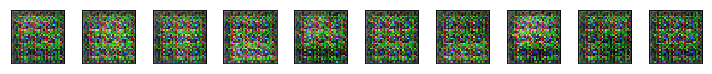

Epoch:   6/25 Discriminator Loss:  1.6164  Generator Loss:  0.6138
Epoch:   7/25 Discriminator Loss:  1.5444  Generator Loss:  1.1654
Epoch:   8/25 Discriminator Loss:  1.3264  Generator Loss:  1.5593
Epoch:   9/25 Discriminator Loss:  1.2276  Generator Loss:  0.9497
Epoch:  10/25 Discriminator Loss:  1.9731  Generator Loss:  2.3272


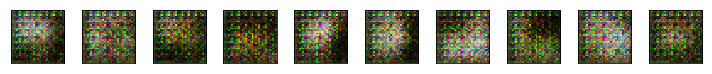

Epoch:  11/25 Discriminator Loss:  3.9364  Generator Loss:  4.3484
Epoch:  12/25 Discriminator Loss:  4.0496  Generator Loss:  4.2431
Epoch:  13/25 Discriminator Loss:  4.2676  Generator Loss:  4.5191
Epoch:  14/25 Discriminator Loss:  1.7257  Generator Loss:  3.1386
Epoch:  15/25 Discriminator Loss:  2.9226  Generator Loss:  3.1658


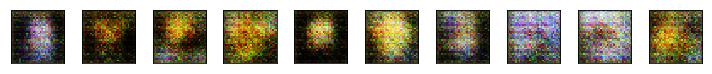

Epoch:  16/25 Discriminator Loss:  1.9472  Generator Loss:  1.9395
Epoch:  17/25 Discriminator Loss:  1.7874  Generator Loss:  1.9463
Epoch:  18/25 Discriminator Loss:  1.7513  Generator Loss:  1.9106
Epoch:  19/25 Discriminator Loss:  1.4586  Generator Loss:  1.4998
Epoch:  20/25 Discriminator Loss:  1.7680  Generator Loss:  1.3879


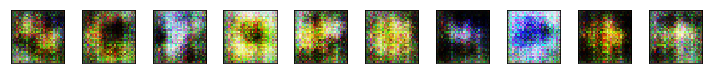

Epoch:  21/25 Discriminator Loss:  1.7754  Generator Loss:  1.4061
Epoch:  22/25 Discriminator Loss:  1.8590  Generator Loss:  1.2864
Epoch:  23/25 Discriminator Loss:  2.7969  Generator Loss:  3.3487
Epoch:  24/25 Discriminator Loss:  1.9799  Generator Loss:  1.5719
Epoch:  25/25 Discriminator Loss:  2.4103  Generator Loss:  4.2971


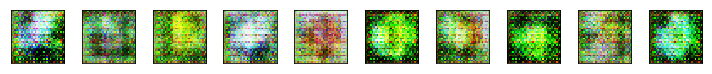

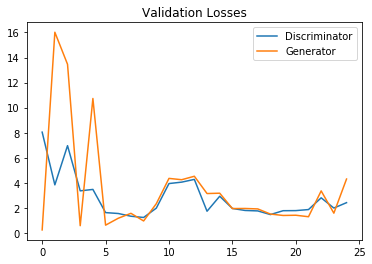

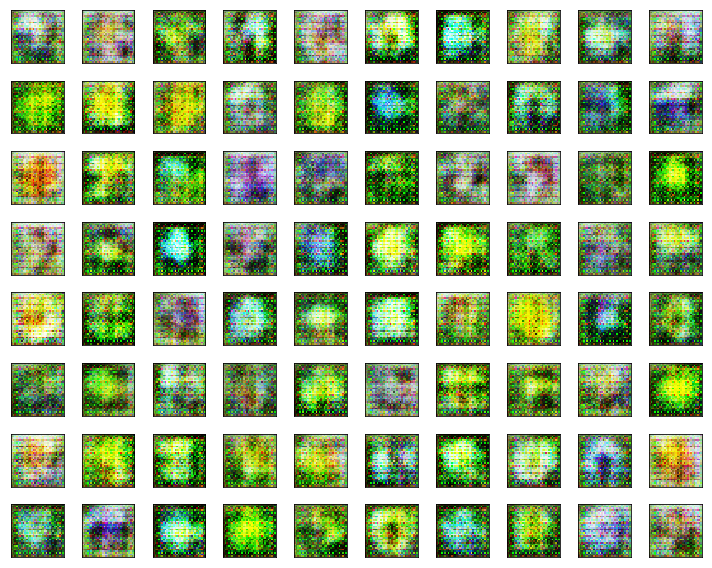

In [127]:
train(g_learning_rate=0.0002, g_beta_1=0.3, d_learning_rate=0.001, d_beta_1=0.3, leaky_alpha=0.2)

In [0]:
train(g_learning_rate=0.0001, g_beta_1=0.3, d_learning_rate=0.0015, d_beta_1=0.3, leaky_alpha=0.2)

In [0]:
train(g_learning_rate=0.0001, g_beta_1=0.3, d_learning_rate=0.001, d_beta_1=0.3, leaky_alpha=0.2)

In [0]:
train(g_learning_rate=0.0002, g_beta_1=0.3, d_learning_rate=0.001, d_beta_1=0.3, leaky_alpha=0.2)

In [0]:
#Dropping down batch to 64 and eval to 12

train(g_learning_rate=0.0002, g_beta_1=0.3, d_learning_rate=0.001, d_beta_1=0.3, leaky_alpha=0.2)

In [0]:
train(g_learning_rate=0.0002, g_beta_1=0.2, d_learning_rate=0.001, d_beta_1=0.2, leaky_alpha=0.2)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/25 Discriminator Loss:  2.0479  Generator Loss:  3.9991
Epoch:   2/25 Discriminator Loss:  1.4906  Generator Loss:  3.6068
Epoch:   3/25 Discriminator Loss:  1.8378  Generator Loss:  1.7311
Epoch:   4/25 Discriminator Loss:  2.0468  Generator Loss:  2.5563
Epoch:   5/25 Discriminator Loss:  1.0593  Generator Loss:  1.8221


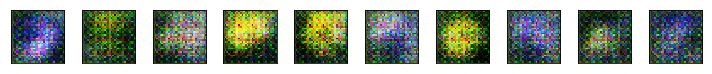

Epoch:   6/25 Discriminator Loss:  2.2730  Generator Loss:  2.3772
Epoch:   7/25 Discriminator Loss:  1.3175  Generator Loss:  1.6883
Epoch:   8/25 Discriminator Loss:  1.6444  Generator Loss:  1.5627
Epoch:   9/25 Discriminator Loss:  1.5125  Generator Loss:  1.3636
Epoch:  10/25 Discriminator Loss:  1.5783  Generator Loss:  1.4114


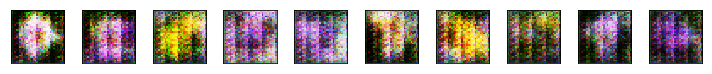

Epoch:  11/25 Discriminator Loss:  1.5268  Generator Loss:  1.3376
Epoch:  12/25 Discriminator Loss:  1.5763  Generator Loss:  1.9406
Epoch:  13/25 Discriminator Loss:  1.6771  Generator Loss:  1.7944
Epoch:  14/25 Discriminator Loss:  2.0807  Generator Loss:  2.1589
Epoch:  15/25 Discriminator Loss:  3.1286  Generator Loss:  3.6240


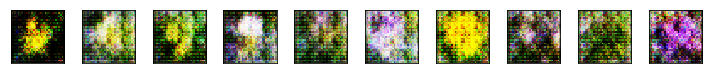

Epoch:  16/25 Discriminator Loss:  1.6144  Generator Loss:  2.5700
Epoch:  17/25 Discriminator Loss:  3.9480  Generator Loss:  5.1029
Epoch:  18/25 Discriminator Loss:  2.7240  Generator Loss:  2.9251
Epoch:  19/25 Discriminator Loss:  2.4549  Generator Loss:  2.1192
Epoch:  20/25 Discriminator Loss:  3.3018  Generator Loss:  4.1820


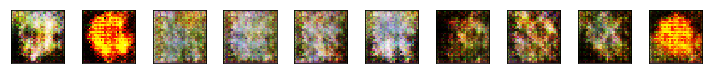

Epoch:  21/25 Discriminator Loss:  2.2004  Generator Loss:  2.5641
Epoch:  22/25 Discriminator Loss:  2.8179  Generator Loss:  4.3550
Epoch:  23/25 Discriminator Loss:  3.7211  Generator Loss:  4.4464
Epoch:  24/25 Discriminator Loss:  2.5737  Generator Loss:  2.9593
Epoch:  25/25 Discriminator Loss:  1.9470  Generator Loss:  2.6249


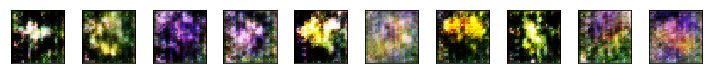

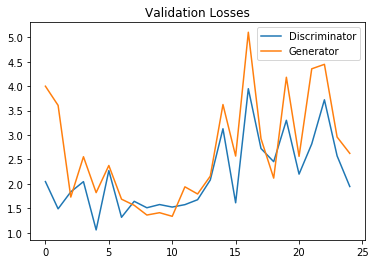

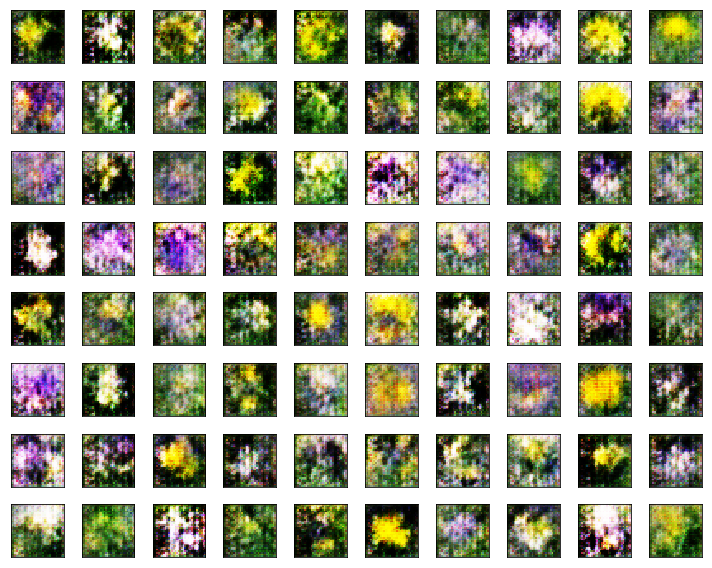

In [140]:
train(g_learning_rate=0.0002, g_beta_1=0.2, d_learning_rate=0.001, d_beta_1=0.2, leaky_alpha=0.2)

In [0]:
train(g_learning_rate=0.0003, g_beta_1=0.2, d_learning_rate=0.001, d_beta_1=0.2, leaky_alpha=0.2)

In [0]:
train(g_learning_rate=0.0003, g_beta_1=0.4, d_learning_rate=0.001, d_beta_1=0.2, leaky_alpha=0.2)

In [0]:
train(g_learning_rate=0.00035, g_beta_1=0.4, d_learning_rate=0.001, d_beta_1=0.2, leaky_alpha=0.2)

In [0]:
#Epochs 25 Batch 32 Eval 12

train(g_learning_rate=0.0002, g_beta_1=0.2, d_learning_rate=0.001, d_beta_1=0.2, leaky_alpha=0.2)

In [0]:
train(g_learning_rate=0.0002, g_beta_1=0.2, d_learning_rate=0.001, d_beta_1=0.2, leaky_alpha=0.2)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/50 Discriminator Loss:  1.1327  Generator Loss:  1.2077
Epoch:   2/50 Discriminator Loss:  5.8484  Generator Loss:  3.3268
Epoch:   3/50 Discriminator Loss:  1.2669  Generator Loss:  2.0346
Epoch:   4/50 Discriminator Loss:  1.6271  Generator Loss:  1.8417
Epoch:   5/50 Discriminator Loss:  2.0536  Generator Loss:  0.9061


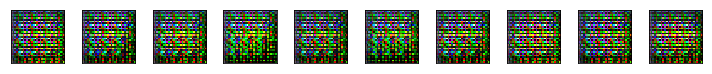

Epoch:   6/50 Discriminator Loss:  1.6972  Generator Loss:  1.2784
Epoch:   7/50 Discriminator Loss:  2.4965  Generator Loss:  4.2687
Epoch:   8/50 Discriminator Loss:  1.3650  Generator Loss:  1.3875
Epoch:   9/50 Discriminator Loss:  1.4671  Generator Loss:  2.0269
Epoch:  10/50 Discriminator Loss:  2.1091  Generator Loss:  1.9642


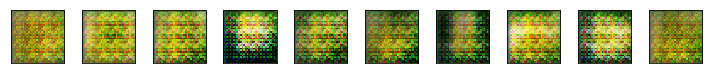

Epoch:  11/50 Discriminator Loss:  1.8197  Generator Loss:  2.5172
Epoch:  12/50 Discriminator Loss:  1.1799  Generator Loss:  1.4355
Epoch:  13/50 Discriminator Loss:  3.9282  Generator Loss:  4.3425
Epoch:  14/50 Discriminator Loss:  1.9699  Generator Loss:  2.0580
Epoch:  15/50 Discriminator Loss:  1.5346  Generator Loss:  1.6406


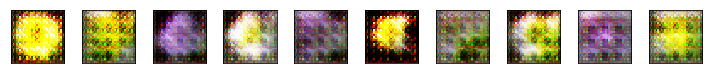

Epoch:  16/50 Discriminator Loss:  1.6649  Generator Loss:  2.0901
Epoch:  17/50 Discriminator Loss:  2.3365  Generator Loss:  2.9369
Epoch:  18/50 Discriminator Loss:  1.5609  Generator Loss:  1.9826
Epoch:  19/50 Discriminator Loss:  2.2998  Generator Loss:  0.8231
Epoch:  20/50 Discriminator Loss:  1.8041  Generator Loss:  2.0915


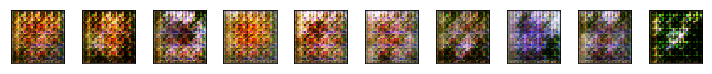

Epoch:  21/50 Discriminator Loss:  1.7676  Generator Loss:  2.4836
Epoch:  22/50 Discriminator Loss:  3.4289  Generator Loss:  3.9270
Epoch:  23/50 Discriminator Loss:  1.7807  Generator Loss:  1.5013
Epoch:  24/50 Discriminator Loss:  2.3733  Generator Loss:  2.4894
Epoch:  25/50 Discriminator Loss:  2.0918  Generator Loss:  1.9812


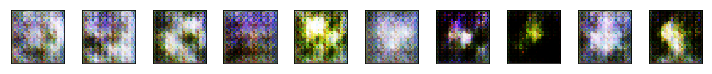

Epoch:  26/50 Discriminator Loss:  2.3074  Generator Loss:  2.8176
Epoch:  27/50 Discriminator Loss:  2.4576  Generator Loss:  2.5550
Epoch:  28/50 Discriminator Loss:  1.9000  Generator Loss:  1.7232
Epoch:  29/50 Discriminator Loss:  1.3054  Generator Loss:  1.8150
Epoch:  30/50 Discriminator Loss:  1.9618  Generator Loss:  1.8860


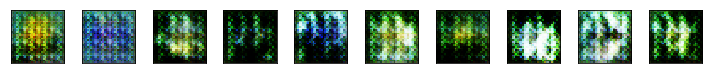

Epoch:  31/50 Discriminator Loss:  1.8409  Generator Loss:  2.0665
Epoch:  32/50 Discriminator Loss:  2.1849  Generator Loss:  3.0293
Epoch:  33/50 Discriminator Loss:  1.6083  Generator Loss:  2.2878
Epoch:  34/50 Discriminator Loss:  2.5775  Generator Loss:  2.7796
Epoch:  35/50 Discriminator Loss:  1.5080  Generator Loss:  1.7983


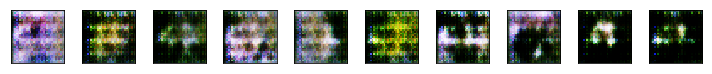

Epoch:  36/50 Discriminator Loss:  2.6796  Generator Loss:  3.3615
Epoch:  37/50 Discriminator Loss:  1.5700  Generator Loss:  1.7719
Epoch:  38/50 Discriminator Loss:  1.3656  Generator Loss:  1.4601
Epoch:  39/50 Discriminator Loss:  2.2648  Generator Loss:  2.6880
Epoch:  40/50 Discriminator Loss:  2.0498  Generator Loss:  2.3424


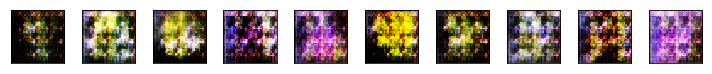

Epoch:  41/50 Discriminator Loss:  2.7201  Generator Loss:  2.9560
Epoch:  42/50 Discriminator Loss:  2.2121  Generator Loss:  2.8482
Epoch:  43/50 Discriminator Loss:  2.3459  Generator Loss:  2.7234
Epoch:  44/50 Discriminator Loss:  2.4546  Generator Loss:  3.3908
Epoch:  45/50 Discriminator Loss:  1.6035  Generator Loss:  1.8146


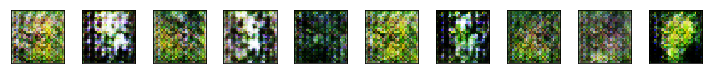

Epoch:  46/50 Discriminator Loss:  1.7426  Generator Loss:  2.5184
Epoch:  47/50 Discriminator Loss:  1.7984  Generator Loss:  2.0749
Epoch:  48/50 Discriminator Loss:  1.7258  Generator Loss:  1.6543
Epoch:  49/50 Discriminator Loss:  2.2894  Generator Loss:  2.8353
Epoch:  50/50 Discriminator Loss:  1.5438  Generator Loss:  2.1356


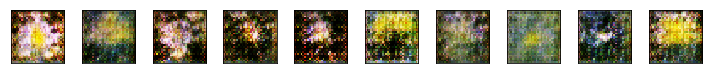

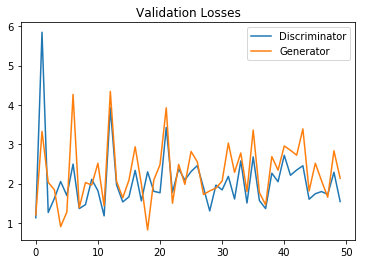

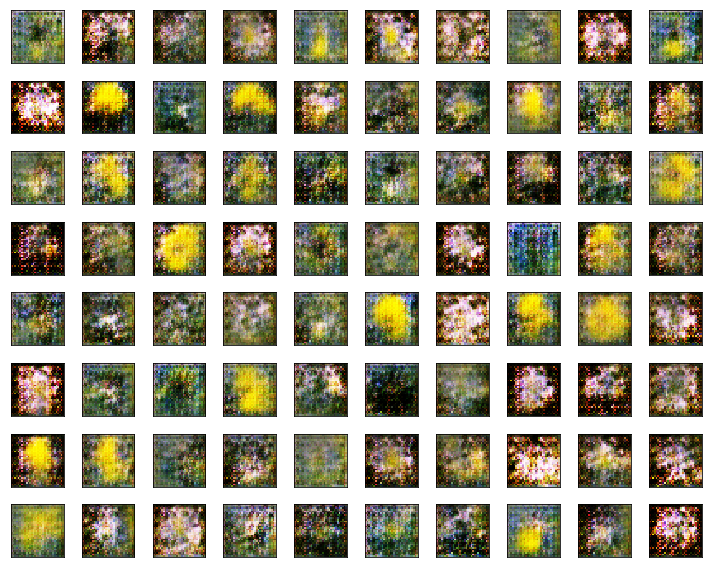

In [159]:
train(g_learning_rate=0.0002, g_beta_1=0.6, d_learning_rate=0.001, d_beta_1=0.6, leaky_alpha=0.2)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/100 Discriminator Loss:  5.8674  Generator Loss:  6.0776
Epoch:   2/100 Discriminator Loss:  2.5604  Generator Loss:  0.3922
Epoch:   3/100 Discriminator Loss: 10.3031  Generator Loss:  8.5592
Epoch:   4/100 Discriminator Loss:  1.8041  Generator Loss:  0.4071
Epoch:   5/100 Discriminator Loss:  1.3409  Generator Loss:  0.9163


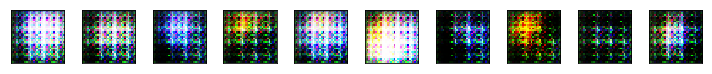

Epoch:   6/100 Discriminator Loss:  1.5040  Generator Loss:  1.2707
Epoch:   7/100 Discriminator Loss:  1.9601  Generator Loss:  2.5495
Epoch:   8/100 Discriminator Loss:  1.9620  Generator Loss:  1.3525
Epoch:   9/100 Discriminator Loss:  2.2204  Generator Loss:  1.8469
Epoch:  10/100 Discriminator Loss:  2.7586  Generator Loss:  3.6342


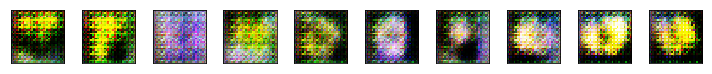

Epoch:  11/100 Discriminator Loss:  2.1443  Generator Loss:  2.3455
Epoch:  12/100 Discriminator Loss:  2.4225  Generator Loss:  2.1836
Epoch:  13/100 Discriminator Loss:  1.9694  Generator Loss:  2.3914
Epoch:  14/100 Discriminator Loss:  2.1839  Generator Loss:  1.9501
Epoch:  15/100 Discriminator Loss:  2.1905  Generator Loss:  2.5608


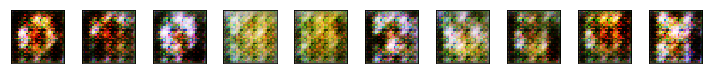

Epoch:  16/100 Discriminator Loss:  1.9276  Generator Loss:  2.2567
Epoch:  17/100 Discriminator Loss:  1.6835  Generator Loss:  1.8412
Epoch:  18/100 Discriminator Loss:  2.1741  Generator Loss:  2.8515
Epoch:  19/100 Discriminator Loss:  3.7665  Generator Loss:  4.1964
Epoch:  20/100 Discriminator Loss:  3.0874  Generator Loss:  3.4123


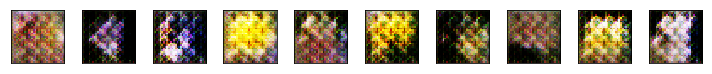

Epoch:  21/100 Discriminator Loss:  1.4349  Generator Loss:  2.0822
Epoch:  22/100 Discriminator Loss:  1.8204  Generator Loss:  1.3185
Epoch:  23/100 Discriminator Loss:  2.0033  Generator Loss:  1.8383
Epoch:  24/100 Discriminator Loss:  1.2137  Generator Loss:  1.5618
Epoch:  25/100 Discriminator Loss:  2.3507  Generator Loss:  2.4138


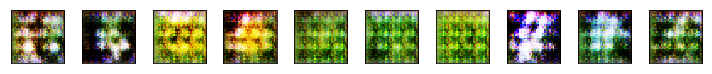

Epoch:  26/100 Discriminator Loss:  2.6727  Generator Loss:  2.0528
Epoch:  27/100 Discriminator Loss:  1.7443  Generator Loss:  2.3910
Epoch:  28/100 Discriminator Loss:  2.3722  Generator Loss:  3.0858
Epoch:  29/100 Discriminator Loss:  2.0896  Generator Loss:  2.3984
Epoch:  30/100 Discriminator Loss:  1.3898  Generator Loss:  0.6540


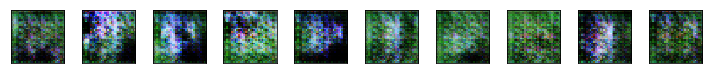

Epoch:  31/100 Discriminator Loss:  1.4630  Generator Loss:  2.4008
Epoch:  32/100 Discriminator Loss:  2.2787  Generator Loss:  2.5550
Epoch:  33/100 Discriminator Loss:  2.1474  Generator Loss:  2.1729
Epoch:  34/100 Discriminator Loss:  2.3947  Generator Loss:  2.9464
Epoch:  35/100 Discriminator Loss:  2.4286  Generator Loss:  2.7462


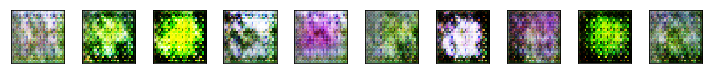

Epoch:  36/100 Discriminator Loss:  1.4786  Generator Loss:  1.6044
Epoch:  37/100 Discriminator Loss:  2.4233  Generator Loss:  2.8856
Epoch:  38/100 Discriminator Loss:  1.7340  Generator Loss:  2.1714
Epoch:  39/100 Discriminator Loss:  1.6130  Generator Loss:  1.2337
Epoch:  40/100 Discriminator Loss:  1.2757  Generator Loss:  1.3263


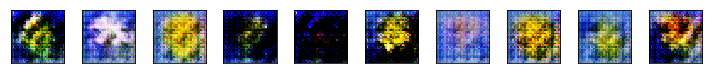

Epoch:  41/100 Discriminator Loss:  1.7554  Generator Loss:  0.2794
Epoch:  42/100 Discriminator Loss:  1.1866  Generator Loss:  0.5714
Epoch:  43/100 Discriminator Loss:  1.7792  Generator Loss:  0.2283
Epoch:  44/100 Discriminator Loss:  2.8237  Generator Loss:  0.0666
Epoch:  45/100 Discriminator Loss:  1.2232  Generator Loss:  0.7891


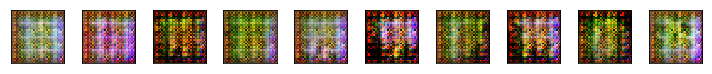

Epoch:  46/100 Discriminator Loss:  1.8770  Generator Loss:  0.3944
Epoch:  47/100 Discriminator Loss:  1.2544  Generator Loss:  1.8265
Epoch:  48/100 Discriminator Loss:  1.1871  Generator Loss:  1.7913
Epoch:  49/100 Discriminator Loss:  2.6377  Generator Loss:  2.9691
Epoch:  50/100 Discriminator Loss:  1.6119  Generator Loss:  2.3759


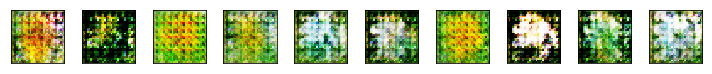

Epoch:  51/100 Discriminator Loss:  1.8238  Generator Loss:  2.1108
Epoch:  52/100 Discriminator Loss:  2.2701  Generator Loss:  2.6434
Epoch:  53/100 Discriminator Loss:  2.4155  Generator Loss:  3.5051
Epoch:  54/100 Discriminator Loss:  1.7810  Generator Loss:  1.6413
Epoch:  55/100 Discriminator Loss:  1.5348  Generator Loss:  1.9530


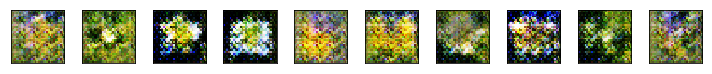

Epoch:  56/100 Discriminator Loss:  1.4223  Generator Loss:  1.6792
Epoch:  57/100 Discriminator Loss:  1.2312  Generator Loss:  0.9557
Epoch:  58/100 Discriminator Loss:  1.7136  Generator Loss:  2.1465
Epoch:  59/100 Discriminator Loss:  1.7787  Generator Loss:  1.8729
Epoch:  60/100 Discriminator Loss:  1.4700  Generator Loss:  1.5500


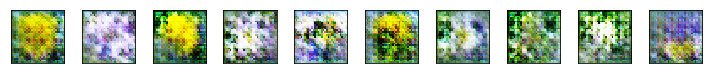

Epoch:  61/100 Discriminator Loss:  2.3633  Generator Loss:  2.7978
Epoch:  62/100 Discriminator Loss:  1.6930  Generator Loss:  2.4057
Epoch:  63/100 Discriminator Loss:  1.7227  Generator Loss:  1.2067
Epoch:  64/100 Discriminator Loss:  1.8115  Generator Loss:  2.5762
Epoch:  65/100 Discriminator Loss:  1.8330  Generator Loss:  1.8875


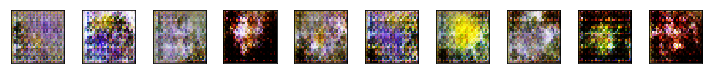

Epoch:  66/100 Discriminator Loss:  1.7597  Generator Loss:  2.0541
Epoch:  67/100 Discriminator Loss:  1.7286  Generator Loss:  2.1506
Epoch:  68/100 Discriminator Loss:  1.8592  Generator Loss:  1.8936
Epoch:  69/100 Discriminator Loss:  2.2720  Generator Loss:  2.4649
Epoch:  70/100 Discriminator Loss:  1.7913  Generator Loss:  2.0552


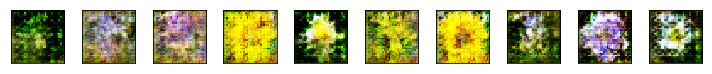

Epoch:  71/100 Discriminator Loss:  1.4482  Generator Loss:  1.3206
Epoch:  72/100 Discriminator Loss:  1.2831  Generator Loss:  1.2476
Epoch:  73/100 Discriminator Loss:  1.8564  Generator Loss:  1.9782
Epoch:  74/100 Discriminator Loss:  1.7756  Generator Loss:  2.1208
Epoch:  75/100 Discriminator Loss:  1.9643  Generator Loss:  3.0729


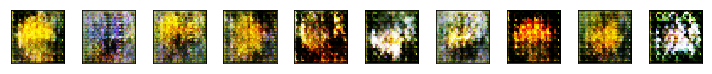

Epoch:  76/100 Discriminator Loss:  1.2620  Generator Loss:  1.2902
Epoch:  77/100 Discriminator Loss:  1.2292  Generator Loss:  1.3404
Epoch:  78/100 Discriminator Loss:  1.6203  Generator Loss:  2.3071
Epoch:  79/100 Discriminator Loss:  2.1239  Generator Loss:  1.5359
Epoch:  80/100 Discriminator Loss:  1.5334  Generator Loss:  1.5325


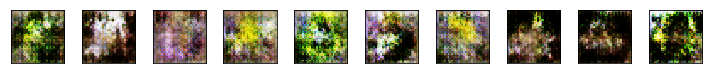

Epoch:  81/100 Discriminator Loss:  1.7427  Generator Loss:  1.0508
Epoch:  82/100 Discriminator Loss:  1.8497  Generator Loss:  3.1217
Epoch:  83/100 Discriminator Loss:  1.5269  Generator Loss:  1.7275
Epoch:  84/100 Discriminator Loss:  1.3308  Generator Loss:  1.8216
Epoch:  85/100 Discriminator Loss:  0.7950  Generator Loss:  1.3721


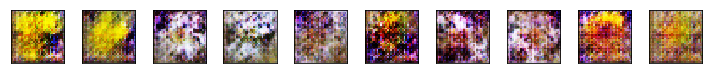

Epoch:  86/100 Discriminator Loss:  1.2744  Generator Loss:  1.1578
Epoch:  87/100 Discriminator Loss:  1.7267  Generator Loss:  2.5876
Epoch:  88/100 Discriminator Loss:  1.4941  Generator Loss:  1.5232
Epoch:  89/100 Discriminator Loss:  1.3910  Generator Loss:  1.4530
Epoch:  90/100 Discriminator Loss:  1.6998  Generator Loss:  2.0129


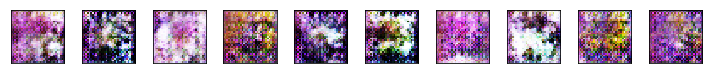

Epoch:  91/100 Discriminator Loss:  2.4315  Generator Loss:  3.5413
Epoch:  92/100 Discriminator Loss:  2.0298  Generator Loss:  2.1092
Epoch:  93/100 Discriminator Loss:  1.1540  Generator Loss:  1.3703
Epoch:  94/100 Discriminator Loss:  1.6860  Generator Loss:  2.5570
Epoch:  95/100 Discriminator Loss:  1.5881  Generator Loss:  2.5835


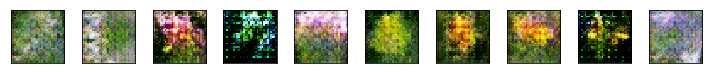

Epoch:  96/100 Discriminator Loss:  2.1259  Generator Loss:  2.3761
Epoch:  97/100 Discriminator Loss:  1.8569  Generator Loss:  2.2305
Epoch:  98/100 Discriminator Loss:  2.6318  Generator Loss:  2.8425
Epoch:  99/100 Discriminator Loss:  1.5453  Generator Loss:  2.8187
Epoch: 100/100 Discriminator Loss:  1.1561  Generator Loss:  1.8424


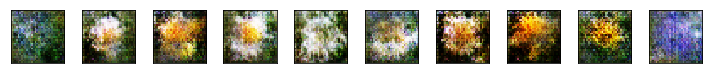

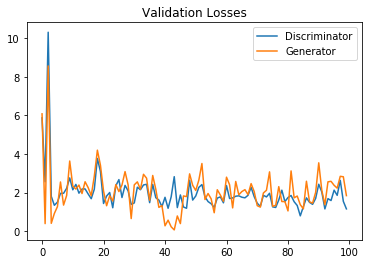

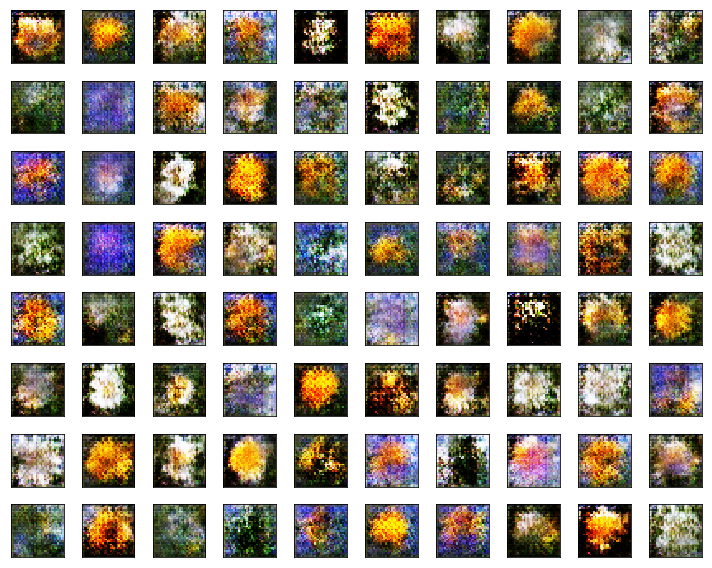

In [165]:
#Batch size 16 eval 12 epochs 100 extra layer on discriminator

train(g_learning_rate=0.0002, g_beta_1=0.6, d_learning_rate=0.001, d_beta_1=0.6, leaky_alpha=0.2)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/100 Discriminator Loss:  3.2084  Generator Loss:  4.8464
Epoch:   2/100 Discriminator Loss:  2.6467  Generator Loss:  4.2624
Epoch:   3/100 Discriminator Loss:  1.6495  Generator Loss:  2.3242
Epoch:   4/100 Discriminator Loss:  3.9567  Generator Loss:  2.3286
Epoch:   5/100 Discriminator Loss:  1.8921  Generator Loss:  7.0018


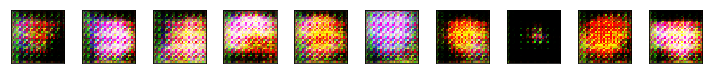

Epoch:   6/100 Discriminator Loss:  2.3545  Generator Loss:  2.7938
Epoch:   7/100 Discriminator Loss:  1.4113  Generator Loss:  1.1319
Epoch:   8/100 Discriminator Loss:  2.0854  Generator Loss:  2.1393
Epoch:   9/100 Discriminator Loss:  2.6723  Generator Loss:  0.6326
Epoch:  10/100 Discriminator Loss:  1.9075  Generator Loss:  2.7839


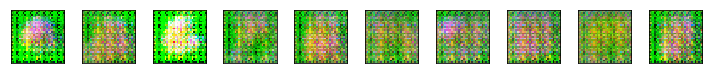

Epoch:  11/100 Discriminator Loss:  2.7086  Generator Loss:  1.6956
Epoch:  12/100 Discriminator Loss:  4.2034  Generator Loss:  5.9300
Epoch:  13/100 Discriminator Loss:  3.0710  Generator Loss:  4.2150
Epoch:  14/100 Discriminator Loss:  5.9224  Generator Loss:  5.2848
Epoch:  15/100 Discriminator Loss:  7.3102  Generator Loss:  7.5181


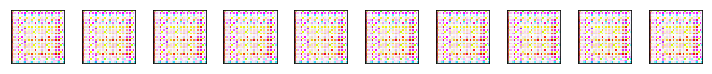

Epoch:  16/100 Discriminator Loss: 11.5553  Generator Loss:  2.9549
Epoch:  17/100 Discriminator Loss: 14.5664  Generator Loss:  9.6255
Epoch:  18/100 Discriminator Loss: 11.8211  Generator Loss: 12.3311
Epoch:  19/100 Discriminator Loss:  9.4336  Generator Loss: 12.0591
Epoch:  20/100 Discriminator Loss:  6.5025  Generator Loss:  9.8988


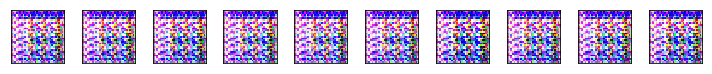

Epoch:  21/100 Discriminator Loss: 15.8966  Generator Loss: 14.4952
Epoch:  22/100 Discriminator Loss:  3.0584  Generator Loss:  1.6366
Epoch:  23/100 Discriminator Loss:  2.1628  Generator Loss:  1.7623
Epoch:  24/100 Discriminator Loss:  1.9613  Generator Loss:  2.4593
Epoch:  25/100 Discriminator Loss:  2.5139  Generator Loss:  2.4555


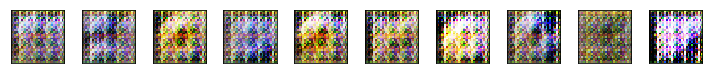

Epoch:  26/100 Discriminator Loss:  1.2821  Generator Loss:  1.2624
Epoch:  27/100 Discriminator Loss:  2.0149  Generator Loss:  1.7428
Epoch:  28/100 Discriminator Loss:  1.4605  Generator Loss:  0.9034
Epoch:  29/100 Discriminator Loss:  1.9116  Generator Loss:  1.7895
Epoch:  30/100 Discriminator Loss:  1.7184  Generator Loss:  1.7930


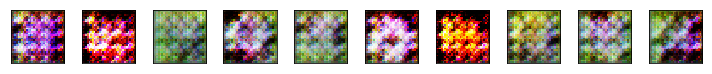

Epoch:  31/100 Discriminator Loss:  1.7700  Generator Loss:  0.8200
Epoch:  32/100 Discriminator Loss:  1.4599  Generator Loss:  0.6576
Epoch:  33/100 Discriminator Loss:  1.6583  Generator Loss:  2.1195
Epoch:  34/100 Discriminator Loss:  1.0763  Generator Loss:  1.4180
Epoch:  35/100 Discriminator Loss:  1.2532  Generator Loss:  1.4972


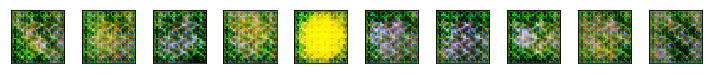

Epoch:  36/100 Discriminator Loss:  1.5716  Generator Loss:  0.5910
Epoch:  37/100 Discriminator Loss:  1.4285  Generator Loss:  0.4975
Epoch:  38/100 Discriminator Loss:  1.1089  Generator Loss:  1.3383
Epoch:  39/100 Discriminator Loss:  2.2997  Generator Loss:  2.5861
Epoch:  40/100 Discriminator Loss:  1.4341  Generator Loss:  0.8219


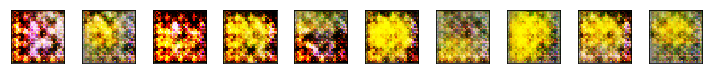

Epoch:  41/100 Discriminator Loss:  2.4526  Generator Loss:  2.2899
Epoch:  42/100 Discriminator Loss:  1.6228  Generator Loss:  1.6925
Epoch:  43/100 Discriminator Loss:  1.3449  Generator Loss:  2.7886
Epoch:  44/100 Discriminator Loss:  1.3336  Generator Loss:  0.4384
Epoch:  45/100 Discriminator Loss:  1.3210  Generator Loss:  1.7067


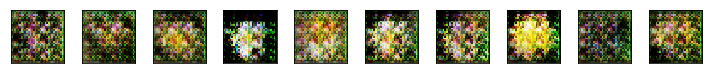

Epoch:  46/100 Discriminator Loss:  1.5046  Generator Loss:  1.3645
Epoch:  47/100 Discriminator Loss:  2.1122  Generator Loss:  2.6838
Epoch:  48/100 Discriminator Loss:  0.8027  Generator Loss:  1.3281
Epoch:  49/100 Discriminator Loss:  1.2021  Generator Loss:  1.2613
Epoch:  50/100 Discriminator Loss:  1.5939  Generator Loss:  1.5309


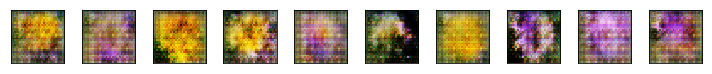

Epoch:  51/100 Discriminator Loss:  1.8032  Generator Loss:  1.8909
Epoch:  52/100 Discriminator Loss:  1.7352  Generator Loss:  1.7894
Epoch:  53/100 Discriminator Loss:  2.2882  Generator Loss:  0.8744
Epoch:  54/100 Discriminator Loss:  1.6345  Generator Loss:  1.3257
Epoch:  55/100 Discriminator Loss:  1.7097  Generator Loss:  2.7339


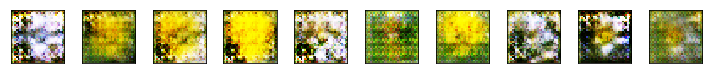

Epoch:  56/100 Discriminator Loss:  1.4044  Generator Loss:  1.6877
Epoch:  57/100 Discriminator Loss:  1.2094  Generator Loss:  4.6315
Epoch:  58/100 Discriminator Loss:  1.5611  Generator Loss:  2.2388
Epoch:  59/100 Discriminator Loss:  2.0165  Generator Loss:  1.2552
Epoch:  60/100 Discriminator Loss:  1.2620  Generator Loss:  1.0819


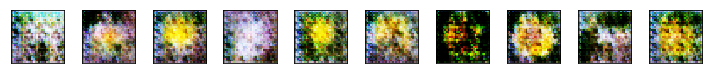

Epoch:  61/100 Discriminator Loss:  1.9930  Generator Loss:  1.5502
Epoch:  62/100 Discriminator Loss:  1.8967  Generator Loss:  2.1743
Epoch:  63/100 Discriminator Loss:  0.9635  Generator Loss:  1.3368
Epoch:  64/100 Discriminator Loss:  2.6455  Generator Loss:  2.4962
Epoch:  65/100 Discriminator Loss:  1.0187  Generator Loss:  1.8782


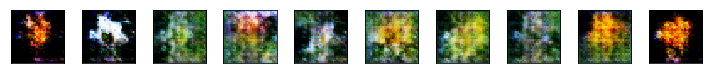

Epoch:  66/100 Discriminator Loss:  1.1604  Generator Loss:  1.4479
Epoch:  67/100 Discriminator Loss:  1.9253  Generator Loss:  2.8975
Epoch:  68/100 Discriminator Loss:  1.3879  Generator Loss:  2.0307
Epoch:  69/100 Discriminator Loss:  1.8723  Generator Loss:  1.9642
Epoch:  70/100 Discriminator Loss:  2.0699  Generator Loss:  1.9614


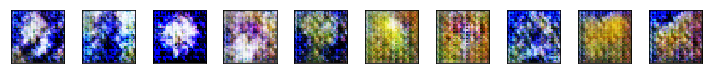

Epoch:  71/100 Discriminator Loss:  1.1603  Generator Loss:  1.4524
Epoch:  72/100 Discriminator Loss:  1.8788  Generator Loss:  3.1675
Epoch:  73/100 Discriminator Loss:  1.1227  Generator Loss:  1.5029
Epoch:  74/100 Discriminator Loss:  1.6085  Generator Loss:  2.3013
Epoch:  75/100 Discriminator Loss:  1.3668  Generator Loss:  1.4244


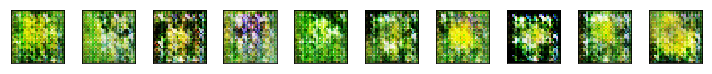

Epoch:  76/100 Discriminator Loss:  0.9020  Generator Loss:  1.0785
Epoch:  77/100 Discriminator Loss:  1.5770  Generator Loss:  2.1714
Epoch:  78/100 Discriminator Loss:  1.5236  Generator Loss:  1.6274
Epoch:  79/100 Discriminator Loss:  1.3549  Generator Loss:  1.6323
Epoch:  80/100 Discriminator Loss:  1.7993  Generator Loss:  3.1718


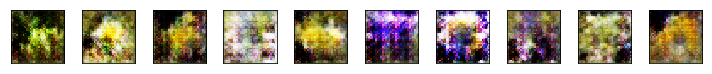

Epoch:  81/100 Discriminator Loss:  2.1971  Generator Loss:  2.9375
Epoch:  82/100 Discriminator Loss:  1.3901  Generator Loss:  1.6005
Epoch:  83/100 Discriminator Loss:  1.4641  Generator Loss:  2.1215
Epoch:  84/100 Discriminator Loss:  2.0396  Generator Loss:  2.7411
Epoch:  85/100 Discriminator Loss:  1.8816  Generator Loss:  2.1879


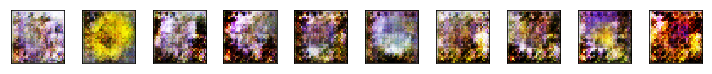

Epoch:  86/100 Discriminator Loss:  2.4834  Generator Loss:  3.4075
Epoch:  87/100 Discriminator Loss:  1.3629  Generator Loss:  1.5459
Epoch:  88/100 Discriminator Loss:  1.2983  Generator Loss:  1.9255
Epoch:  89/100 Discriminator Loss:  2.4361  Generator Loss:  3.8240
Epoch:  90/100 Discriminator Loss:  1.3811  Generator Loss:  3.3259


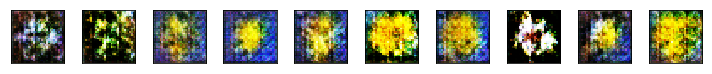

Epoch:  91/100 Discriminator Loss:  1.3217  Generator Loss:  3.1554
Epoch:  92/100 Discriminator Loss:  1.8896  Generator Loss:  1.8029
Epoch:  93/100 Discriminator Loss:  1.6455  Generator Loss:  2.2308
Epoch:  94/100 Discriminator Loss:  2.3591  Generator Loss:  2.6695
Epoch:  95/100 Discriminator Loss:  1.4196  Generator Loss:  2.5469


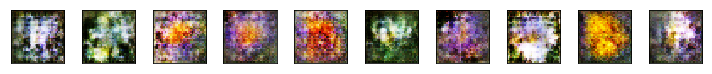

Epoch:  96/100 Discriminator Loss:  2.7481  Generator Loss:  3.1623
Epoch:  97/100 Discriminator Loss:  2.1855  Generator Loss:  4.0728
Epoch:  98/100 Discriminator Loss:  1.2249  Generator Loss:  1.9206
Epoch:  99/100 Discriminator Loss:  2.1835  Generator Loss:  1.4714
Epoch: 100/100 Discriminator Loss:  2.6070  Generator Loss:  2.5869


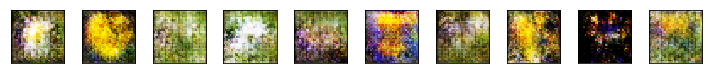

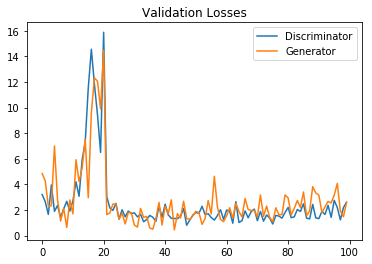

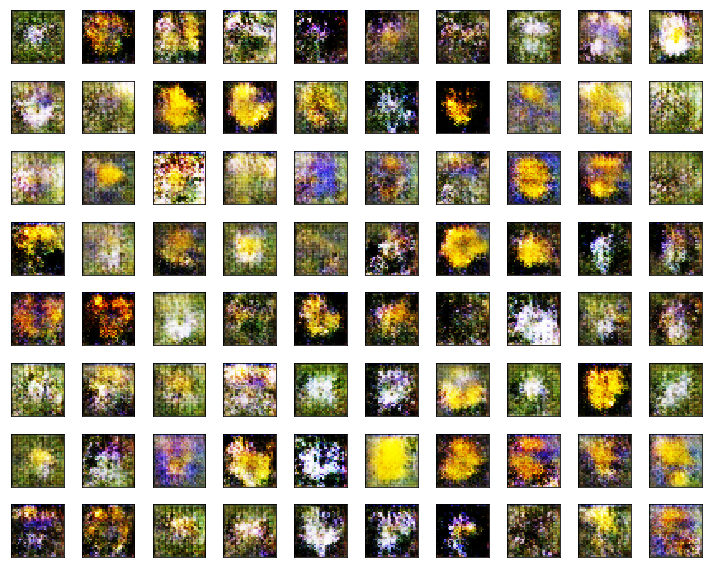

In [175]:
#Batch size 16 eval 12 epochs 100 extra layer on discriminator

train(g_learning_rate=0.0002, g_beta_1=0.6, d_learning_rate=0.001, d_beta_1=0.6, leaky_alpha=0.2)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/100 Discriminator Loss:  1.2704  Generator Loss:  1.5737
Epoch:   2/100 Discriminator Loss:  3.6816  Generator Loss:  4.9796
Epoch:   3/100 Discriminator Loss:  1.7610  Generator Loss:  1.5644
Epoch:   4/100 Discriminator Loss:  1.9081  Generator Loss:  2.9821
Epoch:   5/100 Discriminator Loss:  2.0131  Generator Loss:  1.6443


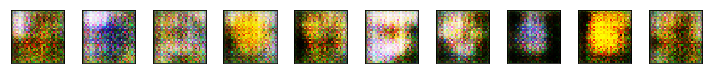

Epoch:   6/100 Discriminator Loss:  2.3265  Generator Loss:  1.9766
Epoch:   7/100 Discriminator Loss:  1.5774  Generator Loss:  1.2484
Epoch:   8/100 Discriminator Loss:  1.9892  Generator Loss:  1.9179
Epoch:   9/100 Discriminator Loss:  1.7784  Generator Loss:  1.8756
Epoch:  10/100 Discriminator Loss:  2.0866  Generator Loss:  1.8326


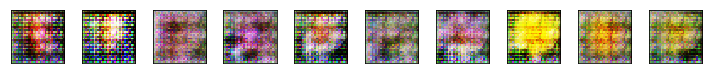

Epoch:  11/100 Discriminator Loss:  1.6978  Generator Loss:  1.6970
Epoch:  12/100 Discriminator Loss:  1.6327  Generator Loss:  1.7192
Epoch:  13/100 Discriminator Loss:  1.3512  Generator Loss:  1.4437
Epoch:  14/100 Discriminator Loss:  1.8609  Generator Loss:  1.4422
Epoch:  15/100 Discriminator Loss:  1.4605  Generator Loss:  1.4256


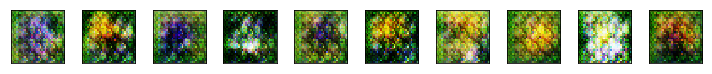

Epoch:  16/100 Discriminator Loss:  1.3328  Generator Loss:  1.1340
Epoch:  17/100 Discriminator Loss:  2.6516  Generator Loss:  5.0073
Epoch:  18/100 Discriminator Loss:  2.2158  Generator Loss:  2.1123
Epoch:  19/100 Discriminator Loss:  1.7931  Generator Loss:  2.0528
Epoch:  20/100 Discriminator Loss:  2.1380  Generator Loss:  2.1482


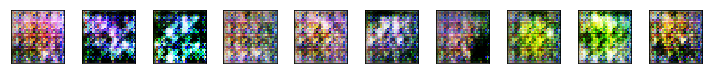

Epoch:  21/100 Discriminator Loss:  2.1039  Generator Loss:  2.0224
Epoch:  22/100 Discriminator Loss:  1.8686  Generator Loss:  1.8710
Epoch:  23/100 Discriminator Loss:  1.8123  Generator Loss:  1.4541
Epoch:  24/100 Discriminator Loss:  2.0439  Generator Loss:  1.9131
Epoch:  25/100 Discriminator Loss:  2.1976  Generator Loss:  2.1792


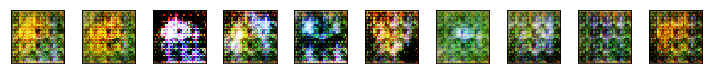

Epoch:  26/100 Discriminator Loss:  1.7169  Generator Loss:  2.2588
Epoch:  27/100 Discriminator Loss:  2.0926  Generator Loss:  2.1123
Epoch:  28/100 Discriminator Loss:  1.7341  Generator Loss:  2.0370
Epoch:  29/100 Discriminator Loss:  1.6756  Generator Loss:  1.8471
Epoch:  30/100 Discriminator Loss:  1.5559  Generator Loss:  1.7880


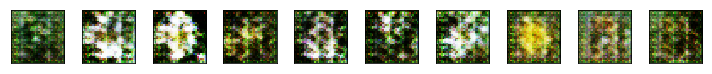

Epoch:  31/100 Discriminator Loss:  1.5026  Generator Loss:  1.3123
Epoch:  32/100 Discriminator Loss:  2.0660  Generator Loss:  1.1656
Epoch:  33/100 Discriminator Loss:  2.3828  Generator Loss:  2.3734
Epoch:  34/100 Discriminator Loss:  1.9827  Generator Loss:  1.6006
Epoch:  35/100 Discriminator Loss:  1.5060  Generator Loss:  1.1089


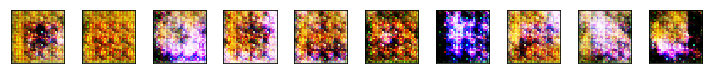

Epoch:  36/100 Discriminator Loss:  1.5435  Generator Loss:  0.9096
Epoch:  37/100 Discriminator Loss:  1.3819  Generator Loss:  1.7978
Epoch:  38/100 Discriminator Loss:  1.5554  Generator Loss:  1.1883
Epoch:  39/100 Discriminator Loss:  1.1919  Generator Loss:  1.2302
Epoch:  40/100 Discriminator Loss:  1.2692  Generator Loss:  1.5756


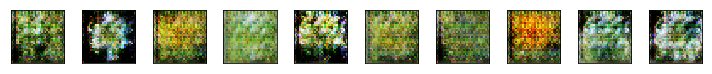

Epoch:  41/100 Discriminator Loss:  1.3102  Generator Loss:  1.1747
Epoch:  42/100 Discriminator Loss:  1.5852  Generator Loss:  2.2647
Epoch:  43/100 Discriminator Loss:  1.6427  Generator Loss:  0.8587
Epoch:  44/100 Discriminator Loss:  1.2393  Generator Loss:  1.1759
Epoch:  45/100 Discriminator Loss:  1.3467  Generator Loss:  1.2630


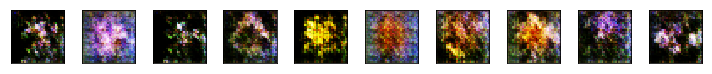

Epoch:  46/100 Discriminator Loss:  1.3836  Generator Loss:  0.4375
Epoch:  47/100 Discriminator Loss:  1.5599  Generator Loss:  0.9947
Epoch:  48/100 Discriminator Loss:  1.0987  Generator Loss:  0.9012
Epoch:  49/100 Discriminator Loss:  1.3849  Generator Loss:  0.8779
Epoch:  50/100 Discriminator Loss:  1.2522  Generator Loss:  0.9109


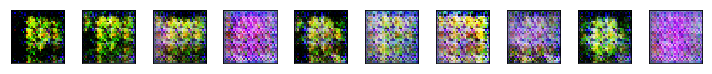

Epoch:  51/100 Discriminator Loss:  2.0501  Generator Loss:  2.4724
Epoch:  52/100 Discriminator Loss:  1.3309  Generator Loss:  1.0519
Epoch:  53/100 Discriminator Loss:  2.3572  Generator Loss:  2.5846
Epoch:  54/100 Discriminator Loss:  1.4444  Generator Loss:  1.3416
Epoch:  55/100 Discriminator Loss:  1.7906  Generator Loss:  2.7969


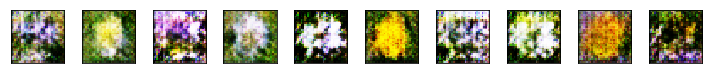

Epoch:  56/100 Discriminator Loss:  1.3164  Generator Loss:  1.5315
Epoch:  57/100 Discriminator Loss:  1.7236  Generator Loss:  1.6339
Epoch:  58/100 Discriminator Loss:  1.6109  Generator Loss:  1.4059
Epoch:  59/100 Discriminator Loss:  1.7189  Generator Loss:  2.2578
Epoch:  60/100 Discriminator Loss:  1.4798  Generator Loss:  1.7205


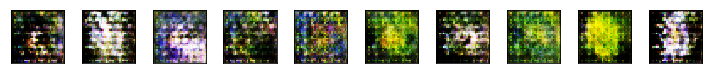

Epoch:  61/100 Discriminator Loss:  1.1733  Generator Loss:  1.0748
Epoch:  62/100 Discriminator Loss:  1.0627  Generator Loss:  1.2202
Epoch:  63/100 Discriminator Loss:  1.5639  Generator Loss:  1.3106
Epoch:  64/100 Discriminator Loss:  1.3841  Generator Loss:  0.9444
Epoch:  65/100 Discriminator Loss:  1.6597  Generator Loss:  1.2463


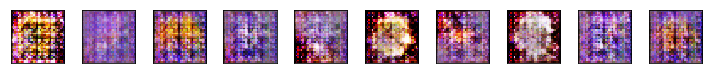

Epoch:  66/100 Discriminator Loss:  1.6966  Generator Loss:  1.3894
Epoch:  67/100 Discriminator Loss:  1.2751  Generator Loss:  0.5361
Epoch:  68/100 Discriminator Loss:  1.5457  Generator Loss:  0.3292
Epoch:  69/100 Discriminator Loss:  1.4367  Generator Loss:  0.8464
Epoch:  70/100 Discriminator Loss:  1.7335  Generator Loss:  1.7906


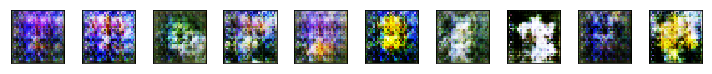

Epoch:  71/100 Discriminator Loss:  1.7800  Generator Loss:  1.9913
Epoch:  72/100 Discriminator Loss:  1.2964  Generator Loss:  1.9122
Epoch:  73/100 Discriminator Loss:  1.5746  Generator Loss:  1.2242
Epoch:  74/100 Discriminator Loss:  1.7734  Generator Loss:  2.3679
Epoch:  75/100 Discriminator Loss:  3.1462  Generator Loss:  2.5154


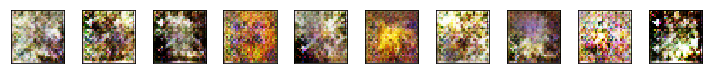

Epoch:  76/100 Discriminator Loss:  1.9468  Generator Loss:  2.2309
Epoch:  77/100 Discriminator Loss:  1.3910  Generator Loss:  0.7598
Epoch:  78/100 Discriminator Loss:  1.7597  Generator Loss:  0.8323
Epoch:  79/100 Discriminator Loss:  1.6546  Generator Loss:  0.4397
Epoch:  80/100 Discriminator Loss:  1.7660  Generator Loss:  0.2841


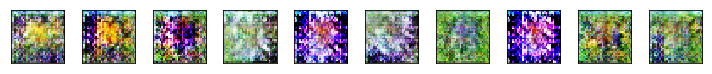

Epoch:  81/100 Discriminator Loss:  1.4049  Generator Loss:  0.4511
Epoch:  82/100 Discriminator Loss:  2.4228  Generator Loss:  0.1108
Epoch:  83/100 Discriminator Loss:  1.4900  Generator Loss:  0.5260
Epoch:  84/100 Discriminator Loss:  1.5054  Generator Loss:  2.0289
Epoch:  85/100 Discriminator Loss:  1.5461  Generator Loss:  1.6105


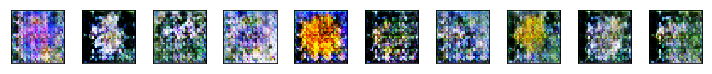

Epoch:  86/100 Discriminator Loss:  2.8463  Generator Loss:  2.3937
Epoch:  87/100 Discriminator Loss:  2.1985  Generator Loss:  2.9351
Epoch:  88/100 Discriminator Loss:  1.7251  Generator Loss:  1.6571
Epoch:  89/100 Discriminator Loss:  2.1848  Generator Loss:  2.5364
Epoch:  90/100 Discriminator Loss:  2.3289  Generator Loss:  2.9866


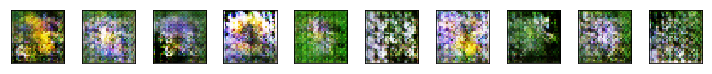

Epoch:  91/100 Discriminator Loss:  2.2083  Generator Loss:  2.4080
Epoch:  92/100 Discriminator Loss:  1.5155  Generator Loss:  2.1221
Epoch:  93/100 Discriminator Loss:  1.4313  Generator Loss:  1.6456
Epoch:  94/100 Discriminator Loss:  1.3707  Generator Loss:  2.0296
Epoch:  95/100 Discriminator Loss:  1.4088  Generator Loss:  2.1674


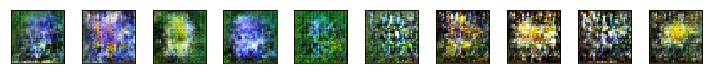

Epoch:  96/100 Discriminator Loss:  1.3132  Generator Loss:  1.1413
Epoch:  97/100 Discriminator Loss:  2.3131  Generator Loss:  2.2654
Epoch:  98/100 Discriminator Loss:  1.9445  Generator Loss:  1.3028
Epoch:  99/100 Discriminator Loss:  1.2070  Generator Loss:  0.7867
Epoch: 100/100 Discriminator Loss:  1.7096  Generator Loss:  1.0612


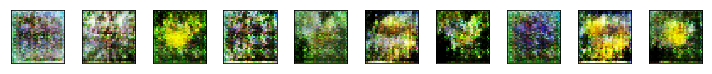

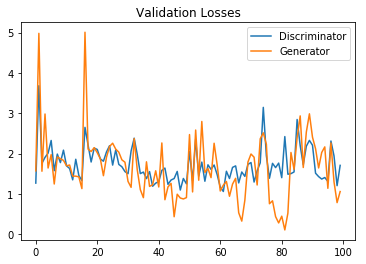

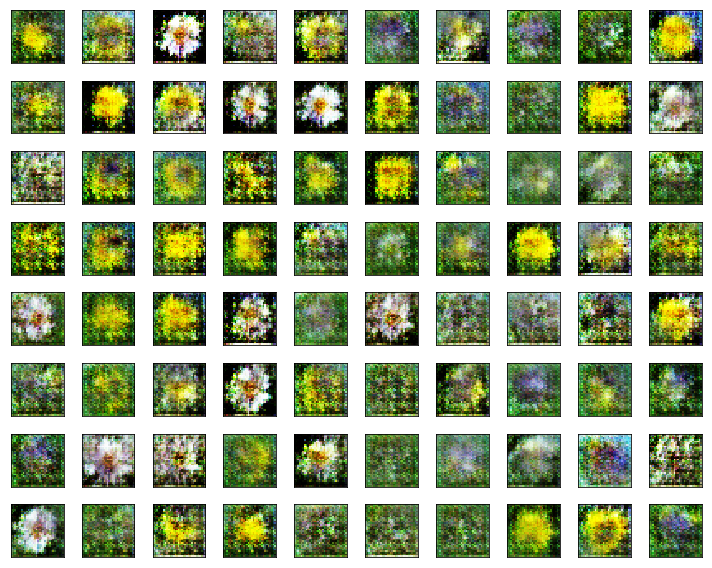

In [178]:
#Epochs 100 Batch 20 Eval 12 Additional Layer with filter size 512 on discriminator 

train(g_learning_rate=0.0002, g_beta_1=0.4, d_learning_rate=0.001, d_beta_1=0.4, leaky_alpha=0.2)